In [1]:
# Number of data points to plot in each axis
num_points = 20

ggap_actual = 1.0
ggap_lo = 0.0
ggap_hi = 1.5

gsyn_actual = 1.0
gsyn_lo = 0.0
gsyn_hi = 1.5

C_actual = 0.015
gc_actual = 0.1
n_timesteps_to_analyze = 1000

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

cached_result_file = 'cached_notebook_results/all_at_a_time.pkl'

if os.path.isfile(cached_result_file):
  print("Loading saved results from pickle file {}".format(cached_result_file))
  with open(cached_result_file, "rb") as f:
    ggap_vals, gsyn_vals, dom_amplitude_vals, dom_amplitude_diff_raw_vals, \
        dom_amplitude_diff_scaled_vals, dom_period_vals, dimensionality_vals = pickle.load(f)
else:
  print("No saved results found. Generating new results.")
  ggap_vals = []
  gsyn_vals = []
  dom_amplitude_vals = []
  dom_amplitude_diff_raw_vals = []
  dom_amplitude_diff_scaled_vals = []
  dom_period_vals = []
  dimensionality_vals = []

  i = 0
  for gsyn in np.linspace(gsyn_lo, gsyn_hi, num_points):
    for ggap in np.linspace(ggap_lo, ggap_hi, num_points):
      i += 1
      start_time = time.time()
      all_dynamics = simulate_until_stable(C_actual, gc_actual, ggap, gsyn)
      fwd_dynamics = all_dynamics[all_dynamics.shape[0] - n_timesteps_to_analyze:,:]
      elapsed_time = time.time() - start_time
      print("Iteration {0}/{1} for gsyn {2:.2f}, ggap {3:.2f} took {4:.2f}s"
            .format(i, num_points ** 2, gsyn, ggap, elapsed_time))
      
      n = fwd_dynamics.shape[0]
      X = fwd_dynamics - fwd_dynamics.mean(axis = 0)
      pca = PCA()
      projected_X = pca.fit_transform(fwd_dynamics)
      dom_mode = projected_X[:,0]
      dom_amplitude = get_amplitude(dom_mode)
      dom_amplitude_diff_raw, dom_amplitude_diff_scaled = get_amplitude_differences(dom_mode)
      dom_period = get_period(dom_mode)
      eigen_vals = get_eigenvalues_from_pca(pca, n)
      dimensionality = get_dimensionality(eigen_vals)

      ggap_vals.append(ggap)
      gsyn_vals.append(gsyn)
      dom_amplitude_vals.append(dom_amplitude)
      dom_amplitude_diff_raw_vals.append(dom_amplitude_diff_raw)
      dom_amplitude_diff_scaled_vals.append(dom_amplitude_diff_scaled)
      dom_period_vals.append(dom_period)
      dimensionality_vals.append(dimensionality)

  with open(cached_result_file, "wb") as f:
    pickle.dump([ggap_vals, gsyn_vals, dom_amplitude_vals, dom_amplitude_diff_raw_vals,
        dom_amplitude_diff_scaled_vals, dom_period_vals, dimensionality_vals], f)

No saved results found. Generating new results.
Simulation length 1000.00, raw amplitude diff 1047.64, scaled amplitude diff 76137.61, amplitude 76137.61
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 289.72, amplitude 289.72
Iteration 1/400 for gsyn 0.00, ggap 0.00 took 0.74s
Simulation length 1000.00, raw amplitude diff 6844.78, scaled amplitude diff 1361310.86, amplitude 1361310.86
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 13.93, amplitude 13.93
Iteration 2/400 for gsyn 0.00, ggap 0.08 took 0.82s
Simulation length 1000.00, raw amplitude diff 7320.54, scaled amplitude diff 1804556.03, amplitude 1804556.03
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 1.97, amplitude 1.97
Iteration 3/400 for gsyn 0.00, ggap 0.16 took 0.97s
Simulation length 1000.00, raw amplitude diff 7561.45, scaled amplitude diff 1677176.79, amplitude 1677176.79
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude 

Simulation length 2000.00, raw amplitude diff 0.91, scaled amplitude diff 53.55, amplitude 53.55
Iteration 31/400 for gsyn 0.08, ggap 0.79 took 1.57s
Simulation length 1000.00, raw amplitude diff 12398.67, scaled amplitude diff 8356.46, amplitude 8356.46
Simulation length 2000.00, raw amplitude diff 0.13, scaled amplitude diff 24.91, amplitude 24.91
Iteration 32/400 for gsyn 0.08, ggap 0.87 took 5.42s
Simulation length 1000.00, raw amplitude diff 12469.08, scaled amplitude diff 9832.26, amplitude 9832.26
Simulation length 2000.00, raw amplitude diff 0.04, scaled amplitude diff 8.94, amplitude 8.94
Iteration 33/400 for gsyn 0.08, ggap 0.95 took 4.25s
Simulation length 1000.00, raw amplitude diff 12527.68, scaled amplitude diff 9421.15, amplitude 9421.15
Simulation length 2000.00, raw amplitude diff 0.09, scaled amplitude diff 12.26, amplitude 12.26
Iteration 34/400 for gsyn 0.08, ggap 1.03 took 1.67s
Simulation length 1000.00, raw amplitude diff 12581.52, scaled amplitude diff 7488.94, 

Simulation length 1000.00, raw amplitude diff 11465.82, scaled amplitude diff 6044.32, amplitude 6044.32
Simulation length 2000.00, raw amplitude diff 0.89, scaled amplitude diff 131.80, amplitude 131.80
Iteration 60/400 for gsyn 0.16, ggap 1.50 took 1.44s
Simulation length 1000.00, raw amplitude diff 988.60, scaled amplitude diff 2484.62, amplitude 2484.62
Simulation length 2000.00, raw amplitude diff 0.01, scaled amplitude diff 30.66, amplitude 30.66
Iteration 61/400 for gsyn 0.24, ggap 0.00 took 0.99s
Simulation length 1000.00, raw amplitude diff 3926.03, scaled amplitude diff 2.73, amplitude 2.73
Simulation length 2000.00, raw amplitude diff 0.08, scaled amplitude diff 0.00, amplitude 0.00
Iteration 62/400 for gsyn 0.24, ggap 0.08 took 4.85s
Simulation length 1000.00, raw amplitude diff 6316.88, scaled amplitude diff 8.16, amplitude 8.16
Simulation length 2000.00, raw amplitude diff 0.08, scaled amplitude diff 0.00, amplitude 0.00
Iteration 63/400 for gsyn 0.24, ggap 0.16 took 3.55

Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 3.78, amplitude 3.78
Iteration 90/400 for gsyn 0.32, ggap 0.71 took 1.88s
Simulation length 1000.00, raw amplitude diff 8672.82, scaled amplitude diff 15945.84, amplitude 15945.84
Simulation length 2000.00, raw amplitude diff 0.03, scaled amplitude diff 602.83, amplitude 602.83
Iteration 91/400 for gsyn 0.32, ggap 0.79 took 1.43s
Simulation length 1000.00, raw amplitude diff 8718.11, scaled amplitude diff 17426.75, amplitude 17426.75
Simulation length 2000.00, raw amplitude diff 0.02, scaled amplitude diff 27.88, amplitude 27.88
Iteration 92/400 for gsyn 0.32, ggap 0.87 took 8.13s
Simulation length 1000.00, raw amplitude diff 8754.57, scaled amplitude diff 20157.29, amplitude 20157.29
Simulation length 2000.00, raw amplitude diff 0.04, scaled amplitude diff 1432.92, amplitude 1432.92
Iteration 93/400 for gsyn 0.32, ggap 0.95 took 1.57s
Simulation length 1000.00, raw amplitude diff 8783.30, scaled amplitude diff 2

Simulation length 2000.00, raw amplitude diff 26.32, scaled amplitude diff 4.31, amplitude 4.31
Simulation length 4000.00, raw amplitude diff 0.00, scaled amplitude diff 0.30, amplitude 0.30
Iteration 120/400 for gsyn 0.39, ggap 1.50 took 11.38s
Simulation length 1000.00, raw amplitude diff 997.81, scaled amplitude diff 16997.02, amplitude 16997.02
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 13.07, amplitude 13.07
Iteration 121/400 for gsyn 0.47, ggap 0.00 took 2.17s
Simulation length 1000.00, raw amplitude diff 4128.55, scaled amplitude diff 9.29, amplitude 9.29
Simulation length 2000.00, raw amplitude diff 0.17, scaled amplitude diff 0.00, amplitude 0.00
Iteration 122/400 for gsyn 0.47, ggap 0.08 took 14.51s
Simulation length 1000.00, raw amplitude diff 5210.81, scaled amplitude diff 287559.15, amplitude 287559.15
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 10.41, amplitude 10.41
Iteration 123/400 for gsyn 0.47, ggap 0.16 to

Simulation length 8000.00, raw amplitude diff 73.93, scaled amplitude diff 0.15, amplitude 0.15
Simulation length 16000.00, raw amplitude diff 85.21, scaled amplitude diff 0.21, amplitude 0.21
Simulation length 32000.00, raw amplitude diff 36.16, scaled amplitude diff 0.10, amplitude 0.10
n_timesteps 64000 is too high! We give up on convergence :(
Iteration 149/400 for gsyn 0.55, ggap 0.63 took 68.91s
Simulation length 1000.00, raw amplitude diff 6135.42, scaled amplitude diff 32.74, amplitude 32.74
Simulation length 2000.00, raw amplitude diff 17.96, scaled amplitude diff 0.06, amplitude 0.06
Simulation length 4000.00, raw amplitude diff 0.29, scaled amplitude diff 0.00, amplitude 0.00
Iteration 150/400 for gsyn 0.55, ggap 0.71 took 6.50s
Simulation length 1000.00, raw amplitude diff 6271.09, scaled amplitude diff 57.31, amplitude 57.31
Simulation length 2000.00, raw amplitude diff 0.29, scaled amplitude diff 0.00, amplitude 0.00
Iteration 151/400 for gsyn 0.55, ggap 0.79 took 2.66s
S

Simulation length 1000.00, raw amplitude diff 5921.54, scaled amplitude diff 148.22, amplitude 148.22
Simulation length 2000.00, raw amplitude diff 0.01, scaled amplitude diff 0.00, amplitude 0.00
Iteration 179/400 for gsyn 0.63, ggap 1.42 took 2.50s
Simulation length 1000.00, raw amplitude diff 5922.92, scaled amplitude diff 186.74, amplitude 186.74
Simulation length 2000.00, raw amplitude diff 0.02, scaled amplitude diff 0.00, amplitude 0.00
Iteration 180/400 for gsyn 0.63, ggap 1.50 took 2.37s
Simulation length 1000.00, raw amplitude diff 1000.33, scaled amplitude diff 3716.21, amplitude 3716.21
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 0.63, amplitude 0.63
Iteration 181/400 for gsyn 0.71, ggap 0.00 took 1.23s
Simulation length 1000.00, raw amplitude diff 3296.54, scaled amplitude diff 389.53, amplitude 389.53
Simulation length 2000.00, raw amplitude diff 0.32, scaled amplitude diff 0.12, amplitude 0.12
Iteration 182/400 for gsyn 0.71, ggap 0.08 took 

Simulation length 2000.00, raw amplitude diff 0.01, scaled amplitude diff 0.00, amplitude 0.00
Iteration 211/400 for gsyn 0.79, ggap 0.79 took 3.45s
Simulation length 1000.00, raw amplitude diff 4868.74, scaled amplitude diff 30.84, amplitude 30.84
Simulation length 2000.00, raw amplitude diff 0.01, scaled amplitude diff 0.00, amplitude 0.00
Iteration 212/400 for gsyn 0.79, ggap 0.87 took 3.25s
Simulation length 1000.00, raw amplitude diff 4937.03, scaled amplitude diff 38.01, amplitude 38.01
Simulation length 2000.00, raw amplitude diff 0.03, scaled amplitude diff 0.00, amplitude 0.00
Iteration 213/400 for gsyn 0.79, ggap 0.95 took 9.68s
Simulation length 1000.00, raw amplitude diff 4990.22, scaled amplitude diff 46.75, amplitude 46.75
Simulation length 2000.00, raw amplitude diff 0.08, scaled amplitude diff 0.00, amplitude 0.00
Iteration 214/400 for gsyn 0.79, ggap 1.03 took 2.93s
Simulation length 1000.00, raw amplitude diff 5029.18, scaled amplitude diff 57.56, amplitude 57.56
Simu

Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 8.25, amplitude 8.25
Iteration 244/400 for gsyn 0.95, ggap 0.24 took 1.52s
Simulation length 1000.00, raw amplitude diff 4008.02, scaled amplitude diff 329.41, amplitude 329.41
Simulation length 2000.00, raw amplitude diff 13.85, scaled amplitude diff 3.55, amplitude 3.55
Simulation length 4000.00, raw amplitude diff 0.16, scaled amplitude diff 0.40, amplitude 0.40
Iteration 245/400 for gsyn 0.95, ggap 0.32 took 4.38s
Simulation length 1000.00, raw amplitude diff 4053.46, scaled amplitude diff 46.08, amplitude 46.08
Simulation length 2000.00, raw amplitude diff 0.39, scaled amplitude diff 0.00, amplitude 0.00
Iteration 246/400 for gsyn 0.95, ggap 0.39 took 7.64s
Simulation length 1000.00, raw amplitude diff 4111.84, scaled amplitude diff 30.56, amplitude 30.56
Simulation length 2000.00, raw amplitude diff 1.51, scaled amplitude diff 0.01, amplitude 0.01
Iteration 247/400 for gsyn 0.95, ggap 0.47 took 2.88s
Simula

Simulation length 1000.00, raw amplitude diff 4396.69, scaled amplitude diff 75.03, amplitude 75.03
Simulation length 2000.00, raw amplitude diff 0.58, scaled amplitude diff 0.00, amplitude 0.00
Iteration 276/400 for gsyn 1.03, ggap 1.18 took 8.39s
Simulation length 1000.00, raw amplitude diff 4418.64, scaled amplitude diff 90.70, amplitude 90.70
Simulation length 2000.00, raw amplitude diff 0.21, scaled amplitude diff 0.00, amplitude 0.00
Iteration 277/400 for gsyn 1.03, ggap 1.26 took 2.08s
Simulation length 1000.00, raw amplitude diff 4433.94, scaled amplitude diff 109.86, amplitude 109.86
Simulation length 2000.00, raw amplitude diff 0.11, scaled amplitude diff 0.00, amplitude 0.00
Iteration 278/400 for gsyn 1.03, ggap 1.34 took 1.99s
Simulation length 1000.00, raw amplitude diff 4448.49, scaled amplitude diff 133.94, amplitude 133.94
Simulation length 2000.00, raw amplitude diff 0.19, scaled amplitude diff 0.00, amplitude 0.00
Iteration 279/400 for gsyn 1.03, ggap 1.42 took 2.16s


Simulation length 1000.00, raw amplitude diff 4027.74, scaled amplitude diff 55.87, amplitude 55.87
Simulation length 2000.00, raw amplitude diff 14.49, scaled amplitude diff 0.10, amplitude 0.10
Simulation length 4000.00, raw amplitude diff 3.00, scaled amplitude diff 0.02, amplitude 0.02
Iteration 308/400 for gsyn 1.18, ggap 0.55 took 11.31s
Simulation length 1000.00, raw amplitude diff 4016.74, scaled amplitude diff 31.57, amplitude 31.57
Simulation length 2000.00, raw amplitude diff 5.62, scaled amplitude diff 0.03, amplitude 0.03
Iteration 309/400 for gsyn 1.18, ggap 0.63 took 3.36s
Simulation length 1000.00, raw amplitude diff 4010.67, scaled amplitude diff 24.19, amplitude 24.19
Simulation length 2000.00, raw amplitude diff 18.97, scaled amplitude diff 0.06, amplitude 0.06
Simulation length 4000.00, raw amplitude diff 61.88, scaled amplitude diff 0.26, amplitude 0.26
Simulation length 8000.00, raw amplitude diff 0.01, scaled amplitude diff 0.00, amplitude 0.00
Iteration 310/400 

Simulation length 1000.00, raw amplitude diff 4243.10, scaled amplitude diff 104.67, amplitude 104.67
Simulation length 2000.00, raw amplitude diff 0.47, scaled amplitude diff 0.00, amplitude 0.00
Iteration 337/400 for gsyn 1.26, ggap 1.26 took 2.01s
Simulation length 1000.00, raw amplitude diff 4263.72, scaled amplitude diff 129.25, amplitude 129.25
Simulation length 2000.00, raw amplitude diff 0.25, scaled amplitude diff 0.00, amplitude 0.00
Iteration 338/400 for gsyn 1.26, ggap 1.34 took 1.75s
Simulation length 1000.00, raw amplitude diff 4283.57, scaled amplitude diff 162.25, amplitude 162.25
Simulation length 2000.00, raw amplitude diff 0.16, scaled amplitude diff 0.00, amplitude 0.00
Iteration 339/400 for gsyn 1.26, ggap 1.42 took 6.12s
Simulation length 1000.00, raw amplitude diff 4301.21, scaled amplitude diff 211.44, amplitude 211.44
Simulation length 2000.00, raw amplitude diff 0.27, scaled amplitude diff 0.00, amplitude 0.00
Iteration 340/400 for gsyn 1.26, ggap 1.50 took 3.

Simulation length 1000.00, raw amplitude diff 3705.64, scaled amplitude diff 6753.32, amplitude 6753.32
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 26.74, amplitude 26.74
Iteration 366/400 for gsyn 1.42, ggap 0.39 took 1.72s
Simulation length 1000.00, raw amplitude diff 3826.57, scaled amplitude diff 397.47, amplitude 397.47
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 119.24, amplitude 119.24
Iteration 367/400 for gsyn 1.42, ggap 0.47 took 1.78s
Simulation length 1000.00, raw amplitude diff 3907.50, scaled amplitude diff 284.77, amplitude 284.77
Simulation length 2000.00, raw amplitude diff 0.01, scaled amplitude diff 1.39, amplitude 1.39
Iteration 368/400 for gsyn 1.42, ggap 0.55 took 3.43s
Simulation length 1000.00, raw amplitude diff 3915.11, scaled amplitude diff 61.39, amplitude 61.39
Simulation length 2000.00, raw amplitude diff 9.96, scaled amplitude diff 72.95, amplitude 72.95
Simulation length 4000.00, raw amplitude d

Simulation length 1000.00, raw amplitude diff 3901.97, scaled amplitude diff 39.38, amplitude 39.38
Simulation length 2000.00, raw amplitude diff 4.14, scaled amplitude diff 0.03, amplitude 0.03
Iteration 391/400 for gsyn 1.50, ggap 0.79 took 2.39s
Simulation length 1000.00, raw amplitude diff 3931.79, scaled amplitude diff 43.30, amplitude 43.30
Simulation length 2000.00, raw amplitude diff 24.49, scaled amplitude diff 0.13, amplitude 0.13
Simulation length 4000.00, raw amplitude diff 11.05, scaled amplitude diff 0.07, amplitude 0.07
Simulation length 8000.00, raw amplitude diff 22.11, scaled amplitude diff 0.13, amplitude 0.13
Simulation length 16000.00, raw amplitude diff 14.87, scaled amplitude diff 0.08, amplitude 0.08
Simulation length 32000.00, raw amplitude diff 8.17, scaled amplitude diff 0.05, amplitude 0.05
n_timesteps 64000 is too high! We give up on convergence :(
Iteration 392/400 for gsyn 1.50, ggap 0.87 took 47.67s
Simulation length 1000.00, raw amplitude diff 3974.06, 

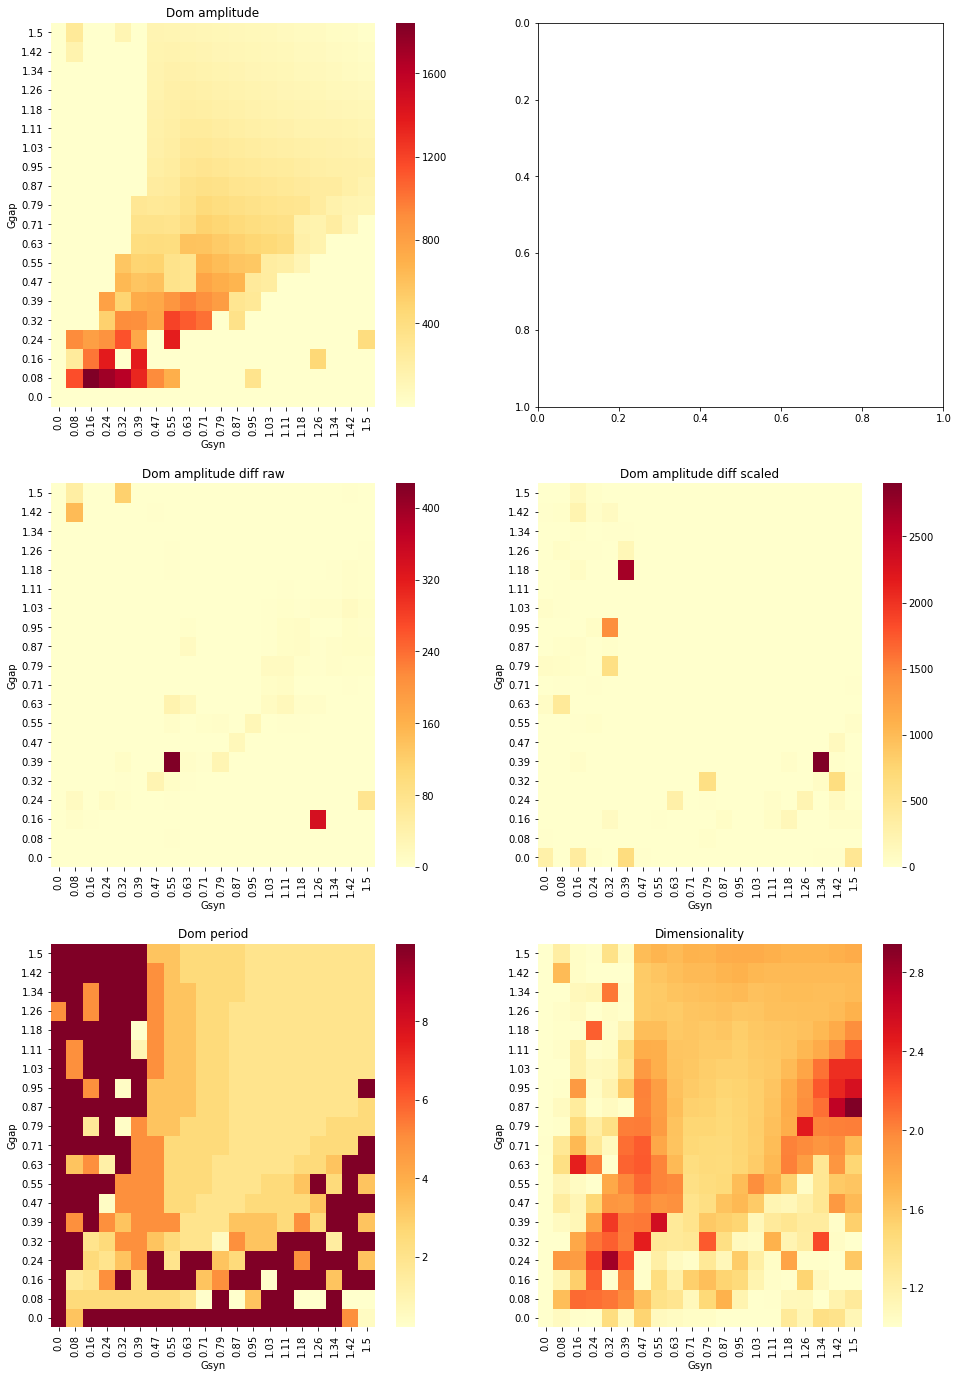

In [7]:
import seaborn as sns
import pandas as pd

def plot_heatmap(ax, ggap_vals, gsyn_vals, output_vals):
  ggap_vals = np.round(ggap_vals, 2)
  gsyn_vals = np.round(gsyn_vals, 2)
  df = pd.DataFrame.from_dict(np.array([ggap_vals,gsyn_vals,output_vals]).T)
  df.columns = ['Ggap','Gsyn','Output']
  df['Output'] = pd.to_numeric(df['Output'])
  pivotted = df.pivot('Ggap','Gsyn','Output')
  # See this for sample color palettes
  # https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/
  return sns.heatmap(pivotted,cmap='YlOrRd', ax = ax)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(16, 24))
ax = axes[0][0]
ax.set_title("Dom amplitude")
plot_heatmap(ax, ggap_vals, gsyn_vals, dom_amplitude_vals)
ax = axes[1][0]
ax.set_title("Dom amplitude diff raw")
plot_heatmap(ax, ggap_vals, gsyn_vals, dom_amplitude_diff_raw_vals)
ax = axes[1][1]
ax.set_title("Dom amplitude diff scaled")
plot_heatmap(ax, ggap_vals, gsyn_vals, dom_amplitude_diff_scaled_vals)
ax = axes[2][0]
ax.set_title("Dom period")
plot_heatmap(ax, ggap_vals, gsyn_vals, dom_period_vals)
ax = axes[2][1]
ax.set_title("Dimensionality")
_ = plot_heatmap(ax, ggap_vals, gsyn_vals, dimensionality_vals)

# Seaborn for some reason inverts the y-axis, so need to un-invert.
for ax in axes.reshape(-1):
  ax.invert_yaxis()